In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


[I 2024-04-01 19:20:28,729] A new study created in memory with name: no-name-2fc5e991-f494-402e-a950-8a730c3de49f


Training time:  1.1373496055603027
Testing time:  0.06738543510437012


[I 2024-04-01 19:20:29,846] Trial 0 finished with value: 0.9880920878539297 and parameters: {'rf_n_estimators': 108, 'rf_max_depth': 6}. Best is trial 0 with value: 0.9880920878539297.
[I 2024-04-01 19:20:30,765] Trial 1 finished with value: 0.9961630060862662 and parameters: {'rf_n_estimators': 75, 'rf_max_depth': 18}. Best is trial 1 with value: 0.9961630060862662.
[I 2024-04-01 19:20:31,298] Trial 2 finished with value: 0.949457528446679 and parameters: {'rf_n_estimators': 84, 'rf_max_depth': 2}. Best is trial 1 with value: 0.9961630060862662.
[I 2024-04-01 19:20:32,577] Trial 3 finished with value: 0.9966922466260916 and parameters: {'rf_n_estimators': 105, 'rf_max_depth': 19}. Best is trial 3 with value: 0.9966922466260916.
[I 2024-04-01 19:20:34,472] Trial 4 finished with value: 0.9964276263561789 and parameters: {'rf_n_estimators': 158, 'rf_max_depth': 30}. Best is trial 3 with value: 0.9966922466260916.
[I 2024-04-01 19:20:36,006] Trial 5 finished with value: 0.9964276263561789

FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9966922466260916], datetime_start=datetime.datetime(2024, 4, 1, 19, 20, 31, 300573), datetime_complete=datetime.datetime(2024, 4, 1, 19, 20, 32, 577697), params={'rf_n_estimators': 105, 'rf_max_depth': 19}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_n_estimators': IntDistribution(high=200, log=False, low=10, step=1), 'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1)}, trial_id=3, value=None)
Train Score: 1.0
Test Score: 0.9962953162212226


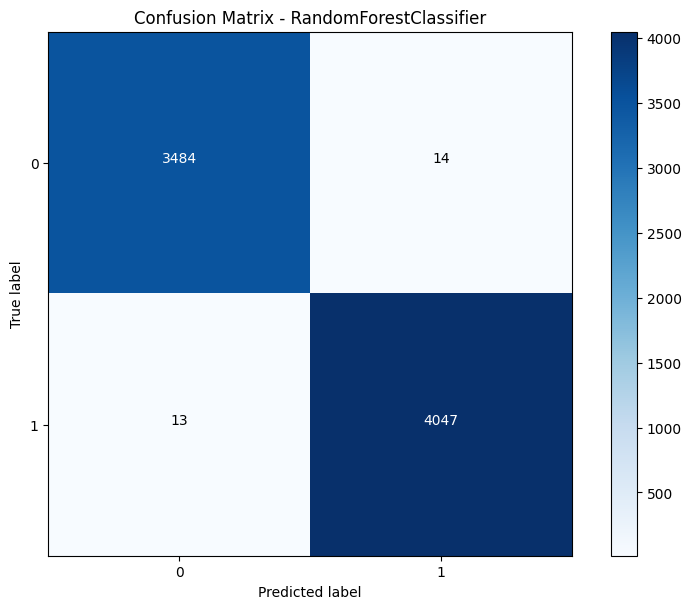

Accuracy: 0.9964276263561789
Precision: 0.9964275906264386
Recall: 0.9964276263561789
F1 Score: 0.9964275909508982
Metric           Value
---------------  --------------------------------------------
Training Time    0.06738543510437012
Best Parameters  {'rf_n_estimators': 105, 'rf_max_depth': 19}
Train Score      1.0
Test Score       0.9962953162212226
Accuracy         0.9964276263561789
Precision        0.9964275906264386
Recall           0.9964276263561789
F1 Score         0.9964275909508982
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3498
           1       1.00      1.00      1.00      4060

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import itertools
from tabulate import tabulate
import joblib
import optuna
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Read data
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

# Function to perform label encoding
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

# Perform label encoding on train and test sets
le(train)
le(test)

# Define features and target
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

# Initialize Random Forest Classifier
rfc = RandomForestClassifier()

# Feature selection using Recursive Feature Elimination (RFE)
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

# Get selected features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i == True]

# Filter the selected features
X_train = X_train[selected_features]

# Standardize features
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Initialize Random Forest Classifier
rfc = RandomForestClassifier()

# Train Random Forest Classifier
start_time = time.time()
rfc.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time - start_time)

# Save the model
joblib.dump(rfc, 'random_forest_model.sav')

# Test Random Forest Classifier
start_time = time.time()
y_test_pred = rfc.predict(x_test)
end_time = time.time()
print("Testing time: ", end_time - start_time)

# Define objective function for Optuna optimization
def objective(trial):
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 200, log=False)
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create Optuna study for Random Forest Classifier
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

# Initialize Random Forest Classifier with best parameters
rf = RandomForestClassifier(n_estimators=study_rf.best_trial.params['rf_n_estimators'],
                             max_depth=study_rf.best_trial.params['rf_max_depth'])

# Train Random Forest Classifier with best parameters
rf.fit(x_train, y_train)

# Calculate train and test scores
rf_train_score = rf.score(x_train, y_train)
rf_test_score = rf.score(x_test, y_test)

# Print train and test scores
print(f"Train Score: {rf_train_score}")
print(f"Test Score: {rf_test_score}")

# Confusion matrix for RandomForestClassifier
cm_rf = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - RandomForestClassifier')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))

thresh = cm_rf.max() / 2.
for i, j in itertools.product(range(cm_rf.shape[0]), range(cm_rf.shape[1])):
    plt.text(j, i, format(cm_rf[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_rf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Showing the plot
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Summary of the code
summary = [
    ["Training Time", end_time - start_time],
    ["Best Parameters", study_rf.best_params],
    ["Train Score", rf_train_score],
    ["Test Score", rf_test_score],
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

print(tabulate(summary, headers=["Metric", "Value"]))

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Training time:  0.8599252700805664
Testing time:  0.00308990478515625


[I 2024-04-01 19:26:11,543] Trial 0 finished with value: 0.9523683514157184 and parameters: {'svc_C': 0.4370109557244207}. Best is trial 0 with value: 0.9523683514157184.
<ipython-input-5-284dc695a4aa>:76: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_C = trial.suggest_loguniform('svc_C', 0.01, 100)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2024-04-01 19:26:12,652] Trial 1 finished with value: 0.9539560730351945 and parameters: {'svc_C': 5.201439593406831}. Best is trial 1 with value: 0.9539560730351945.
<ipython-input-5-284dc695a4aa>:76: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

FrozenTrial(number=25, state=TrialState.COMPLETE, values=[0.9542206933051072], datetime_start=datetime.datetime(2024, 4, 1, 19, 26, 34, 471812), datetime_complete=datetime.datetime(2024, 4, 1, 19, 26, 35, 580953), params={'svc_C': 4.2478827485881485}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_C': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=25, value=None)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train Score: 0.9523080412838834
Test Score: 0.9539560730351945


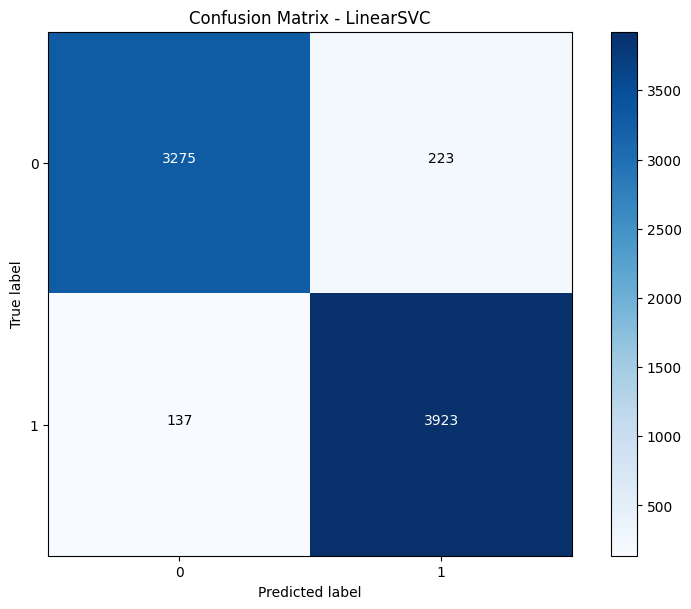

Accuracy: 0.9523683514157184
Precision: 0.9525234925387166
Recall: 0.9523683514157184
F1 Score: 0.9523215391663019
Metric           Value
---------------  -----------------------------
Training Time    0.00308990478515625
Best Parameters  {'svc_C': 4.2478827485881485}
Train Score      0.9523080412838834
Test Score       0.9539560730351945
Accuracy         0.9523683514157184
Precision        0.9525234925387166
Recall           0.9523683514157184
F1 Score         0.9523215391663019
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      3498
           1       0.95      0.97      0.96      4060

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
import itertools
import joblib
import optuna
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Read data
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')

# Function to perform label encoding
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])

# Perform label encoding on train and test sets
le(train)
le(test)

# Define features and target
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

# Initialize Linear SVM Classifier
svc = LinearSVC()

# Feature selection using Recursive Feature Elimination (RFE)
rfe = RFE(svc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

# Get selected features
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i == True]

# Filter the selected features
X_train = X_train[selected_features]

# Standardize features
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

# Initialize Linear SVM Classifier
svc = LinearSVC()

# Train Linear SVM Classifier
start_time = time.time()
svc.fit(x_train, y_train)
end_time = time.time()
print("Training time: ", end_time - start_time)

# Save the model
joblib.dump(svc, 'linear_svm_model.sav')

# Test Linear SVM Classifier
start_time = time.time()
y_test_pred = svc.predict(x_test)
end_time = time.time()
print("Testing time: ", end_time - start_time)

# Define objective function for Optuna optimization
def objective(trial):
    svc_C = trial.suggest_loguniform('svc_C', 0.01, 100)
    classifier_obj = LinearSVC(C=svc_C)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

# Create Optuna study for Linear SVM Classifier
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective, n_trials=30)
print(study_svc.best_trial)

# Initialize Linear SVM Classifier with best parameters
svc = LinearSVC(C=study_svc.best_trial.params['svc_C'])

# Train Linear SVM Classifier with best parameters
svc.fit(x_train, y_train)

# Calculate train and test scores
svc_train_score = svc.score(x_train, y_train)
svc_test_score = svc.score(x_test, y_test)

# Print train and test scores
print(f"Train Score: {svc_train_score}")
print(f"Test Score: {svc_test_score}")

# Confusion matrix for Linear SVM Classifier
cm_svc = confusion_matrix(y_test, y_test_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_svc, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - LinearSVC')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))

thresh = cm_svc.max() / 2.
for i, j in itertools.product(range(cm_svc.shape[0]), range(cm_svc.shape[1])):
    plt.text(j, i, format(cm_svc[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_svc[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Showing the plot
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Summary of the code
summary = [
    ["Training Time", end_time - start_time],
    ["Best Parameters", study_svc.best_params],
    ["Train Score", svc_train_score],
    ["Test Score", svc_test_score],
    ["Accuracy", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1 Score", f1]
]

print(tabulate(summary, headers=["Metric", "Value"]))
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)



In [ ]:
!pip install optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.6 MB/s eta 0:00:00
